## Indice de Teneur en Eau de la Végétation (NDMI)

### Description de l’indicateur

Le **NDMI (Normalized Difference Moisture Index)** est un indice spectral de
télédétection utilisé pour **estimer la teneur en eau de la végétation** et
détecter le **stress hydrique des plantes**. Il permet d’évaluer la santé
physiologique des cultures, des forêts et de la végétation naturelle.

Le principe repose sur la **différence de réflectance entre le proche infrarouge
(NIR) et le moyen infrarouge (SWIR)** :

- la réflectance dans le **NIR** est fortement liée à la structure des feuilles et
  à la biomasse ;
- la réflectance dans le **SWIR** est fortement influencée par la teneur en eau
  dans les tissus végétaux.

Ainsi, un NDMI élevé correspond à une végétation **riche en eau et saine**, tandis
qu’un NDMI faible ou négatif indique **stress hydrique, sécheresse ou végétation
dégradée**.

Les valeurs du NDMI sont comprises entre **−1 et +1** :

- **NDMI négatif** : végétation stressée ou faible humidité dans les feuilles  
- **NDMI proche de 0** : zones en transition ou végétation modérément humide  
- **NDMI positif** : végétation saine et riche en eau  

Le NDMI est particulièrement utilisé pour :
- le suivi de l’humidité de la végétation et le stress hydrique ;
- l’évaluation de la santé des cultures et des forêts ;
- la surveillance environnementale dans les régions sensibles à la sécheresse.

---

### Méthodologie de calcul

Le NDMI est calculé à partir des images multispectrales **Sentinel-2**, en
utilisant les bandes suivantes :

- **B8 (Proche infrarouge – NIR, 842 nm)** : fortement réfléchie par la
  structure des feuilles ;  
- **B11 (Moyen infrarouge – SWIR, 1610 nm)** : absorbée en fonction de la
  teneur en eau des tissus végétaux.

La formule du NDMI est définie comme suit :

$$
NDMI = \frac{NIR - SWIR}{NIR + SWIR}
$$

où :  
- $NIR$ représente la réflectance de la bande **B8** ;  
- $SWIR$ représente la réflectance de la bande **B11**.  

Cette normalisation permet d’obtenir un indicateur **adimensionnel**, borné
entre −1 et +1, facilitant la comparaison spatiale et temporelle de l’humidité
de la végétation.

---

### Remarque méthodologique

Le NDMI est robuste pour détecter le stress hydrique, mais certaines limites
doivent être prises en compte :

- sensibilité aux nuages et aux ombres sur la végétation ;  
- saturation possible dans les zones de végétation très dense ;  
- dépendance à la correction atmosphérique des images.  

Pour des analyses complètes, le NDMI est souvent utilisé **en complément du
NDVI et du NDWI**, permettant de distinguer la végétation saine, les zones
humides et les sols nus ou artificialisés.


NDMI min : -0.3459621
NDMI max : 0.64962626


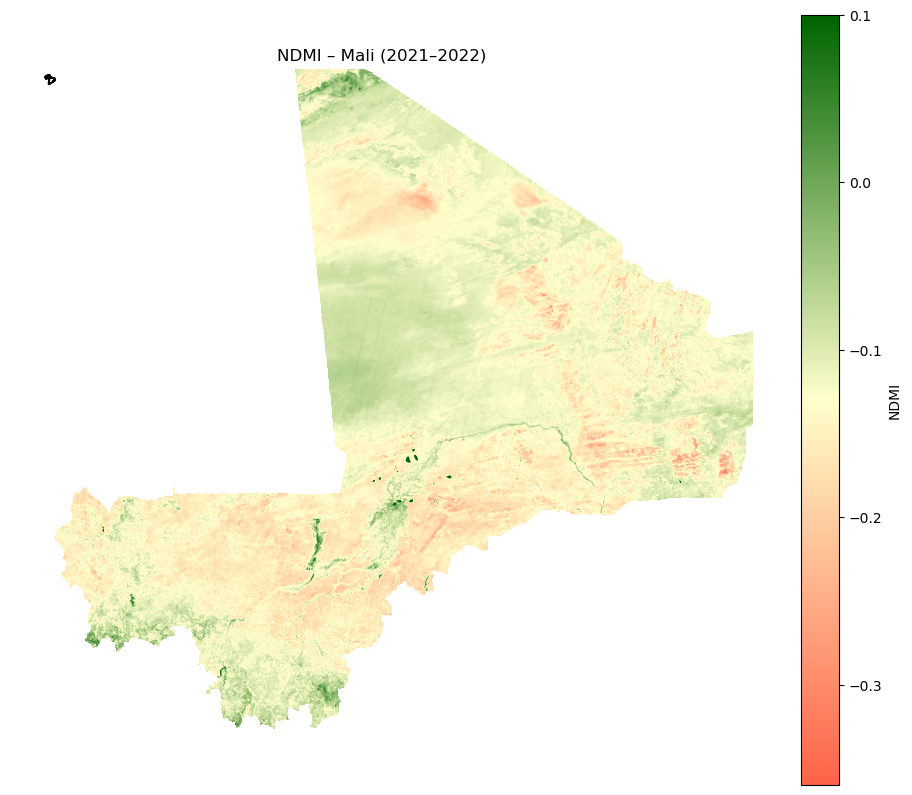

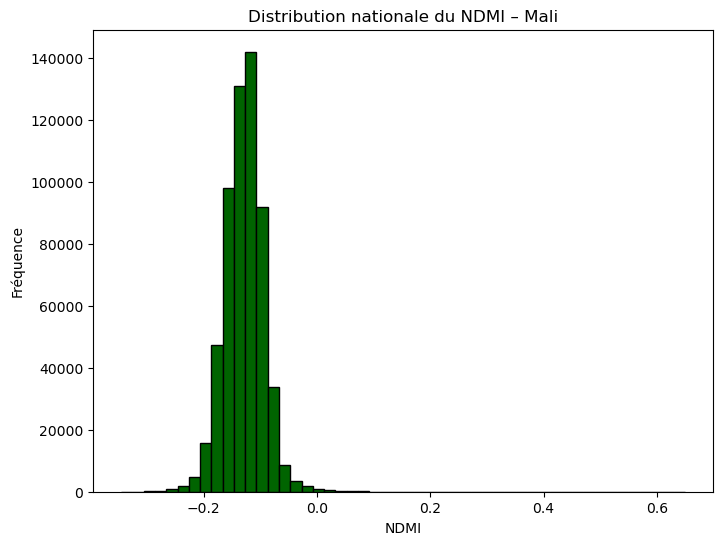

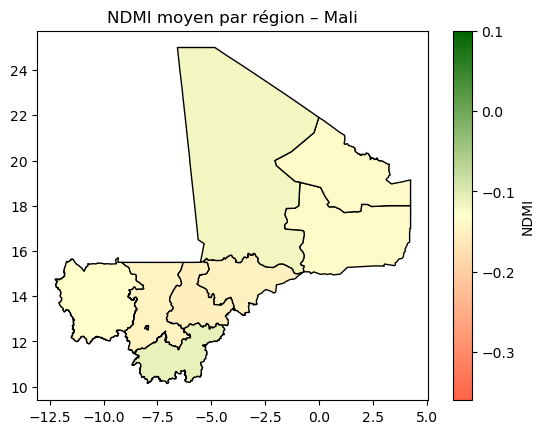

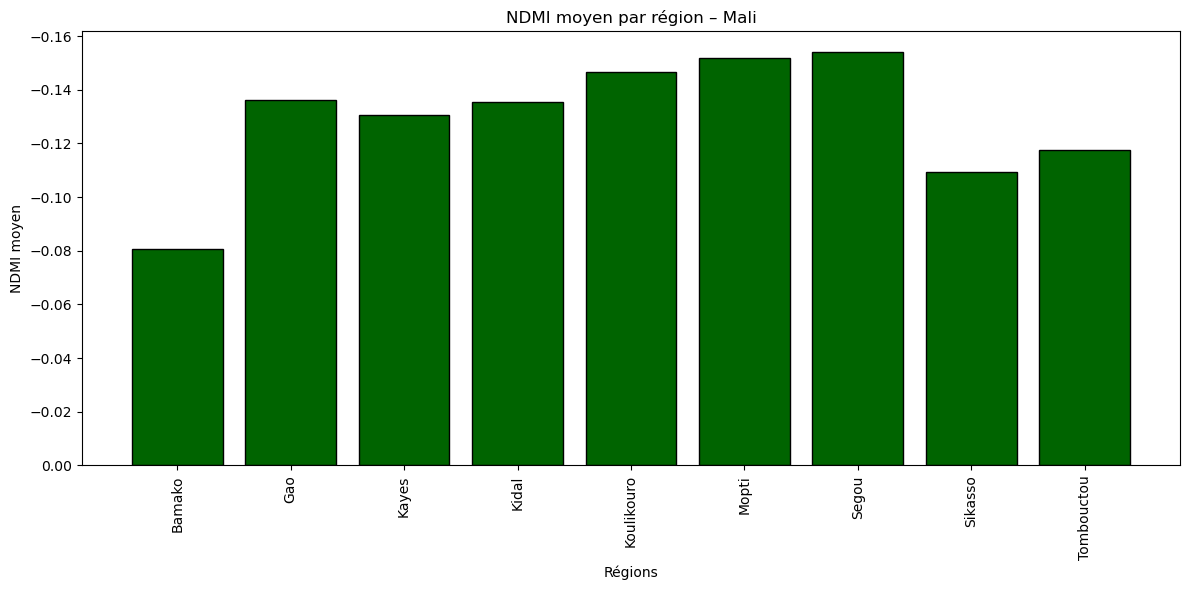

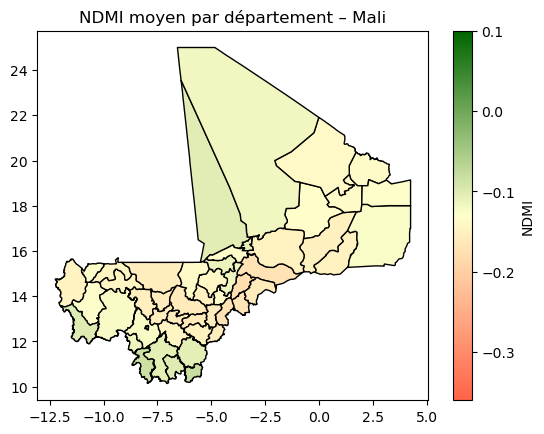

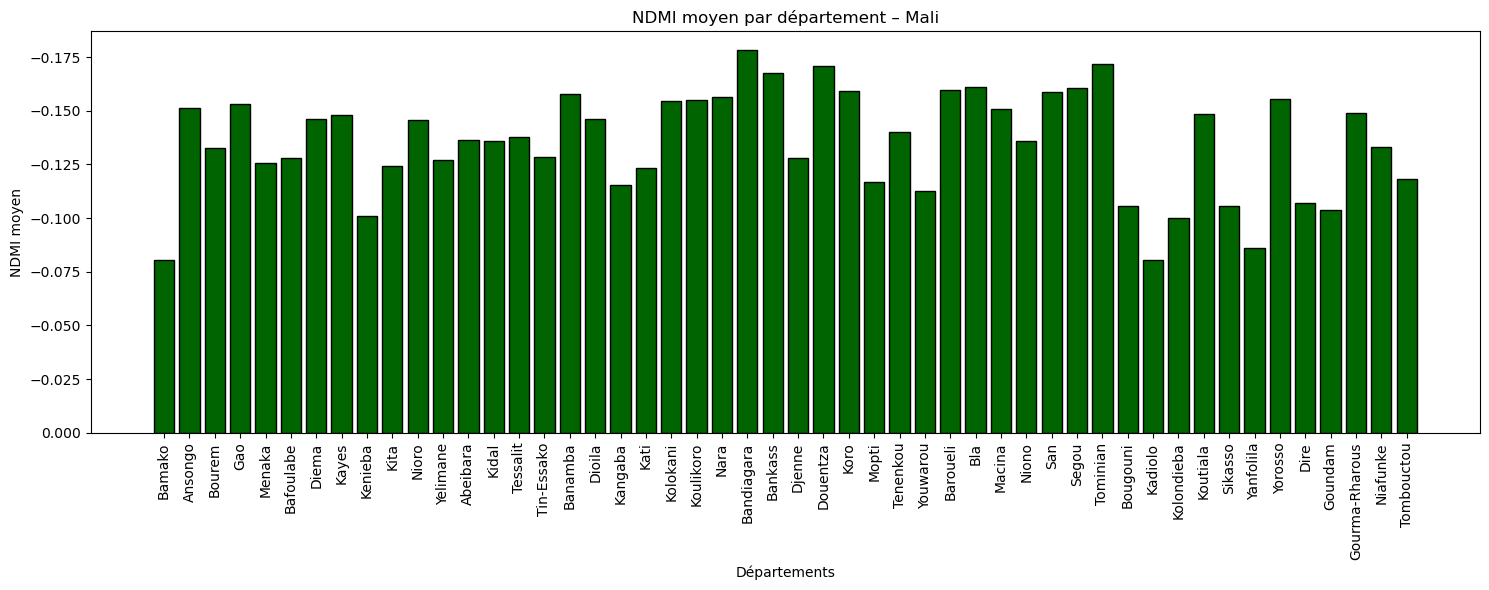

Table départementale NDMI enregistrée dans outputs/NDMI/


In [3]:
# ======================================================
# NDMI.ipynb – Calcul et analyse exploratoire du NDMI
# ======================================================

import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.mask import mask
from rasterio.enums import Resampling
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ======================================================
# 1️⃣ Chemins
# ======================================================
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "..", "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "..", "outputs", "NDMI")
os.makedirs(OUTPUT_DIR, exist_ok=True)

path_nir  = os.path.join(DATA_DIR, "Mali_2022_B8_100m.tif")   # NIR
path_swir = os.path.join(DATA_DIR, "Mali_2022_B11_100m.tif")  # SWIR

factor = 15  # rééchantillonnage pour réduire la résolution

# ======================================================
# 2️⃣ Lecture + rééchantillonnage
# ======================================================
def read_resample(path, factor):
    with rasterio.open(path) as src:
        new_width  = src.width // factor
        new_height = src.height // factor

        data = src.read(
            1,
            out_shape=(new_height, new_width),
            resampling=Resampling.average
        ).astype("float32")

        transform = src.transform * src.transform.scale(
            src.width / new_width,
            src.height / new_height
        )

        profile = src.profile.copy()
        profile.update({
            "height": new_height,
            "width": new_width,
            "transform": transform
        })

    return data, profile

nir, profile  = read_resample(path_nir, factor)
swir, _       = read_resample(path_swir, factor)

# ======================================================
# 3️⃣ Calcul NDMI
# ======================================================
np.seterr(divide="ignore", invalid="ignore")
ndmi = (nir - swir) / (nir + swir)
ndmi = np.where((ndmi < -1) | (ndmi > 1), np.nan, ndmi)

print("NDMI min :", np.nanmin(ndmi))
print("NDMI max :", np.nanmax(ndmi))

# ======================================================
# 4️⃣ Palette continue NDMI
# ======================================================
ndmi_cmap = LinearSegmentedColormap.from_list(
    "ndmi_cmap",
    [
        "#FF6347",  # rouge clair : zones sèches / peu végétalisées
        "#FFFFCC",  # jaune clair : zones moyennement humides
        "#006400"   # vert foncé : zones très humides / végétation dense
    ]
)

ndmi_norm = Normalize(vmin=-0.36, vmax=0.1)

# ======================================================
# 5️⃣ Analyse nationale
# ======================================================
mali = gpd.read_file(os.path.join(DATA_DIR, "mli_admin0.shp"))
mali = mali.to_crs(profile["crs"])

plt.figure(figsize=(12, 10))
plt.imshow(ndmi, cmap=ndmi_cmap, norm=ndmi_norm)
mali.boundary.plot(ax=plt.gca(), edgecolor="black", linewidth=1.5)
plt.colorbar(label="NDMI")
plt.title("NDMI – Mali (2021–2022)")
plt.axis("off")
plt.savefig(os.path.join(OUTPUT_DIR, "NDMI_nationale.png"), dpi=300)
plt.show()

# Histogramme national
plt.figure(figsize=(8, 6))
plt.hist(ndmi[~np.isnan(ndmi)], bins=50, color="#006400", edgecolor="black")
plt.title("Distribution nationale du NDMI – Mali")
plt.xlabel("NDMI")
plt.ylabel("Fréquence")
plt.savefig(os.path.join(OUTPUT_DIR, "NDMI_histogramme_nationale.png"), dpi=300)
plt.show()

# ======================================================
# 6️⃣ Analyse régionale (Admin1)
# ======================================================
regions = gpd.read_file(os.path.join(DATA_DIR, "mli_admin1.shp"))
regions = regions.to_crs(profile["crs"])

regional_ndmi = []

for _, row in regions.iterrows():
    geom = [row.geometry]
    with rasterio.open(path_nir) as src:
        nir_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_swir) as src:
        swir_c, _ = mask(src, geom, crop=True)

    nir_c  = nir_c[0].astype("float32")
    swir_c = swir_c[0].astype("float32")

    ndmi_c = (nir_c - swir_c) / (nir_c + swir_c)
    ndmi_c = np.where((ndmi_c < -1) | (ndmi_c > 1), np.nan, ndmi_c)

    regional_ndmi.append(np.nanmean(ndmi_c))

regions["NDMI"] = regional_ndmi

# Carte régionale
regions.plot(column="NDMI", cmap=ndmi_cmap, norm=ndmi_norm,
             edgecolor="black", legend=True,
             legend_kwds={"label": "NDMI"})
plt.title("NDMI moyen par région – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDMI_regionale.png"), dpi=300)
plt.show()

# Barplot régional
plt.figure(figsize=(12, 6))
plt.bar(regions["shapeName"], regions["NDMI"], color="#006400", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDMI moyen par région – Mali")
plt.xlabel("Régions")
plt.ylabel("NDMI moyen")
plt.gca().invert_yaxis()  # inversé pour esthétique
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDMI_bar_regions.png"), dpi=300)
plt.show()

# ======================================================
# 7️⃣ Analyse départementale (Admin2)
# ======================================================
departements = gpd.read_file(os.path.join(DATA_DIR, "mli_admin2.shp"))
departements = departements.to_crs(profile["crs"])

dept_ndmi = []

for _, row in departements.iterrows():
    geom = [row.geometry]
    with rasterio.open(path_nir) as src:
        nir_c, _ = mask(src, geom, crop=True)
    with rasterio.open(path_swir) as src:
        swir_c, _ = mask(src, geom, crop=True)

    nir_c  = nir_c[0].astype("float32")
    swir_c = swir_c[0].astype("float32")

    ndmi_c = (nir_c - swir_c) / (nir_c + swir_c)
    ndmi_c = np.where((ndmi_c < -1) | (ndmi_c > 1), np.nan, ndmi_c)

    dept_ndmi.append(np.nanmean(ndmi_c))

departements["NDMI"] = dept_ndmi

# Carte départementale
departements.plot(column="NDMI", cmap=ndmi_cmap, norm=ndmi_norm,
                  edgecolor="black", legend=True,
                  legend_kwds={"label": "NDMI"})
plt.title("NDMI moyen par département – Mali")
plt.savefig(os.path.join(OUTPUT_DIR, "NDMI_departementale.png"), dpi=300)
plt.show()

# Barplot départemental
plt.figure(figsize=(15, 6))
plt.bar(departements["shapeName"], departements["NDMI"], color="#006400", edgecolor="black")
plt.xticks(rotation=90)
plt.title("NDMI moyen par département – Mali")
plt.xlabel("Départements")
plt.ylabel("NDMI moyen")
plt.gca().invert_yaxis()  # inversé pour esthétique
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "NDMI_bar_departements.png"), dpi=300)
plt.show()

# Enregistrement CSV
ndmi_table = departements[["shapeName", "NDMI"]].copy()
ndmi_table.to_csv(os.path.join(OUTPUT_DIR, "NDMI_departements.csv"), index=False)
print("Table départementale NDMI enregistrée dans outputs/NDMI/")
